In [1]:
import os
print(os.listdir('C:\\Users\\prave\\Desktop\\praveen kr. sah 190301120043\\5th Semester\\Image Dataset\\flowers'))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


## Importing Various Modules

In [18]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
# from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
# from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

## Preparing the Data

### Making the functions to get the training and validation set from the Images

In [6]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='C:\\Users\\prave\\Desktop\\praveen kr. sah 190301120043\\5th Semester\\Image Dataset\\flowers\\daisy'
FLOWER_SUNFLOWER_DIR='C:\\Users\\prave\\Desktop\\praveen kr. sah 190301120043\\5th Semester\\Image Dataset\\flowers\\sunflower'
FLOWER_TULIP_DIR='C:\\Users\\prave\\Desktop\\praveen kr. sah 190301120043\\5th Semester\\Image Dataset\\flowers\\tulip'
FLOWER_DANDI_DIR='C:\\Users\\prave\\Desktop\\praveen kr. sah 190301120043\\5th Semester\\Image Dataset\\flowers\\dandelion'
FLOWER_ROSE_DIR='C:\\Users\\prave\\Desktop\\praveen kr. sah 190301120043\\5th Semester\\Image Dataset\\flowers\\rose'

In [7]:
def assign_label(img,flower_type):
    return flower_type
    

In [8]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [9]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:04<00:00, 25.00it/s]

104


In [10]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:02<00:00, 39.02it/s]

208


In [11]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:01<00:00, 57.31it/s]

312


In [12]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:01<00:00, 59.99it/s]

416


In [13]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:01<00:00, 62.38it/s]

520


### Visualizing some Random Images

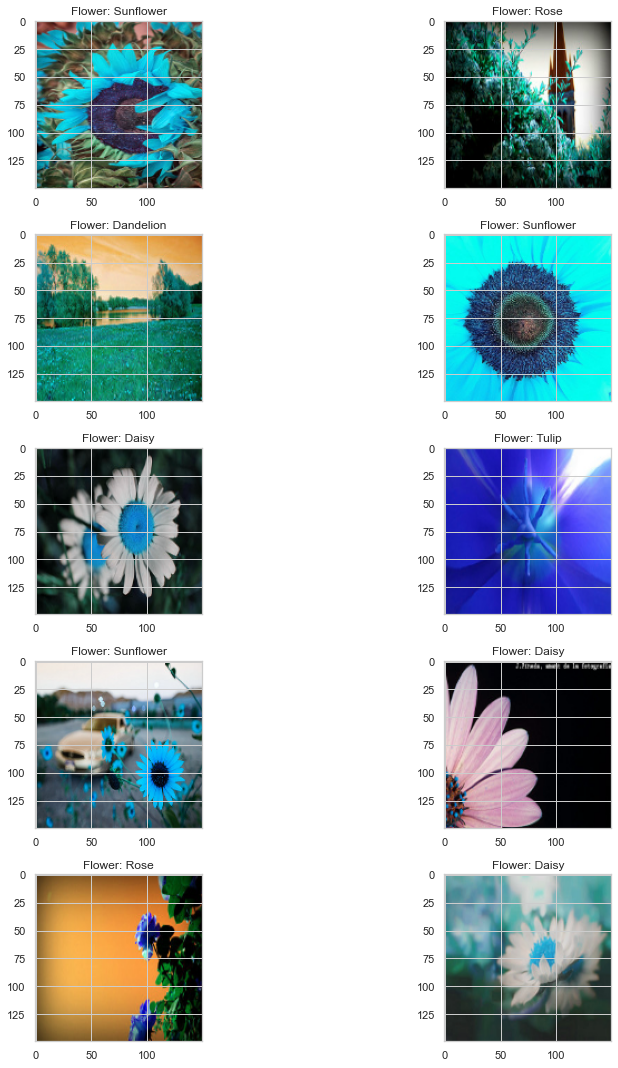

In [14]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

###  Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding

In [19]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=tf.keras.utils.to_categorical(Y,5)
X=np.array(X)
X=X/255

### Splitting into Training and Validation Sets

In [20]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

### Setting the Random Seeds

In [21]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

## Modelling

### Building the ConvNet Model

In [22]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

### Using a LR Annealer

In [23]:
batch_size=80
epochs=20

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

### Data Augmentation to prevent Overfitting

In [24]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

### Compiling the Keras Model & Summary

In [25]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 96)        8

### Fitting on the Training set and making predcitons on the Validation set

In [27]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))


Epoch 1/20
4/4 [==============================] - 34s 7s/step - loss: 1.6190 - accuracy: 0.2226 - val_loss: 1.5805 - val_accuracy: 0.3231
Epoch 2/20
4/4 [==============================] - 15s 4s/step - loss: 1.5400 - accuracy: 0.2806 - val_loss: 1.5972 - val_accuracy: 0.2385
Epoch 3/20
4/4 [==============================] - 15s 4s/step - loss: 1.4208 - accuracy: 0.3500 - val_loss: 1.4178 - val_accuracy: 0.4000
Epoch 4/20
4/4 [==============================] - 15s 4s/step - loss: 1.3708 - accuracy: 0.4032 - val_loss: 1.5080 - val_accuracy: 0.3308
Epoch 5/20
4/4 [==============================] - 14s 4s/step - loss: 1.4159 - accuracy: 0.3484 - val_loss: 1.4334 - val_accuracy: 0.3385
Epoch 6/20
4/4 [==============================] - 15s 4s/step - loss: 1.3402 - accuracy: 0.4344 - val_loss: 1.4152 - val_accuracy: 0.4000
Epoch 7/20
4/4 [==============================] - 15s 4s/step - loss: 1.2739 - accuracy: 0.4656 - val_loss: 1.2031 - val_accuracy: 0.5769
Epoch 8/20
4/4 [==================

In [29]:
model.evaluate(x_test, y_test)

5/5 [==============================] - 1s 269ms/step - loss: 1.2015 - accuracy: 0.5769


[1.2014552354812622, 0.5769230723381042]

## Evaluating the Model Performance

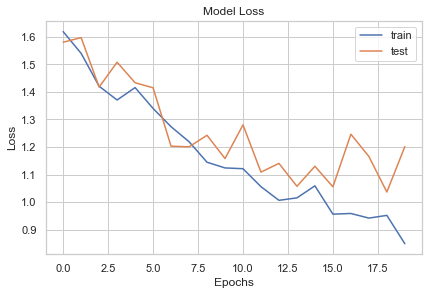

In [30]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

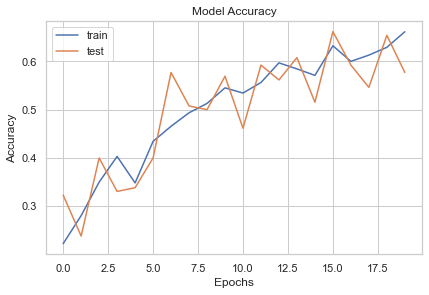

In [31]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

## Visualizing Predictons on the Validation Set

In [32]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

In [33]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

### CORRECTLY CLASSIFIED FLOWER IMAGES

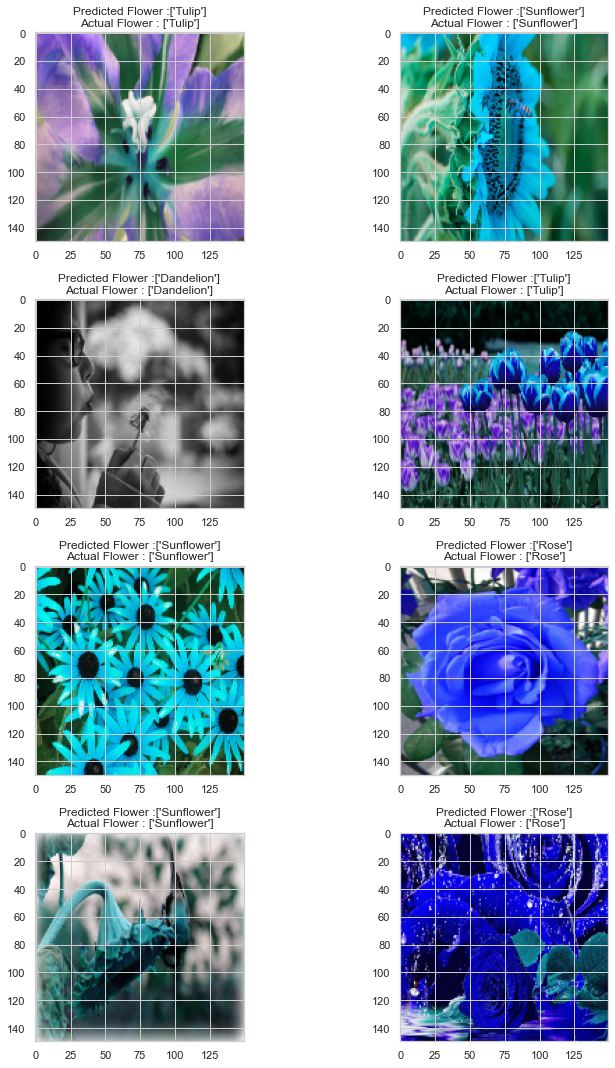

In [34]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower :"+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax(y_test[prop_class[count]])])))
        plt.tight_layout()
        count+=1

### MISCLASSIFIED IMAGES OF FLOWERS

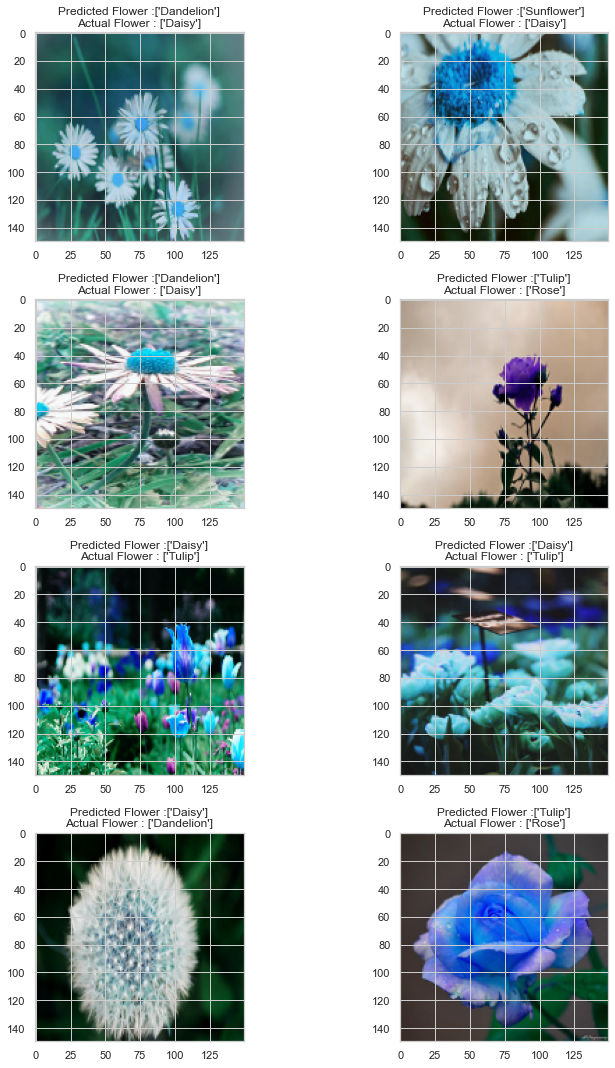

In [36]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower :"+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax(y_test[mis_class[count]])])))
        plt.tight_layout()
        count+=1

## Classification

In [40]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [41]:
score = model.evaluate(x_test, y_test)
model.save("model.h5")

5/5 [==============================] - 1s 282ms/step - loss: 1.2015 - accuracy: 0.5769


In [48]:
predictions = model.predict_(x_test)
predictions[:10] ;# predict 10 images

In [49]:
from sklearn.preprocessing import LabelBinarizer

In [50]:
binarizer = LabelBinarizer() 
binarizer.fit(y_test)

LabelBinarizer()

In [51]:
# predict function
labels = ['daisy', 'rose', 'dandelion', 'sunflower', 'tulip']

def prepare(filepath):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("model.h5")

In [59]:
prediction = model.predict([prepare("C:\\Users\\prave\\Desktop\\praveen kr. sah 190301120043\\5th Semester\\Image Dataset\\flowers\\daisy\\2473825306_62fd5f8785_n.jpg")])
print(labels[(prediction[0])]) 

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-u4kjpz2z\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'
